# Notebook 5: Experiment E2 - Cross-Repository Generalization

**Objective:**
Test whether the model learns real patterns instead of repository-specific quirks.

**Approach:**
- Train on autoland repository alerts
- Test on mozilla-central and mozilla-beta repositories
- Compare with in-distribution performance

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report
)
import warnings
import sys
import os
sys.path.append(os.path.abspath('../src'))
from utils import load_data, get_xgb_model
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data and Check Repositories

In [2]:
# Load preprocessed data using utility function
df_encoded = load_data("../results/data/preprocessed_alerts.csv")

# Also load original data to get repository information
alerts_original = pd.read_csv("../Input/alerts_data.csv")

# Merge to get repository column
# Note: We'll match by index assuming same order
df_with_repo = df_encoded.copy()
df_with_repo['repository'] = alerts_original['alert_summary_repository'].values

print(f"Total dataset shape: {df_with_repo.shape}")
print(f"\nRepository distribution:")
repo_counts = df_with_repo['repository'].value_counts()
print(repo_counts)
print(f"\nTotal unique repositories: {len(repo_counts)}")

Total dataset shape: (17989, 20)

Repository distribution:
repository
autoland           13593
mozilla-beta        3597
firefox-android      796
mozilla-central        2
mozilla-release        1
Name: count, dtype: int64

Total unique repositories: 5


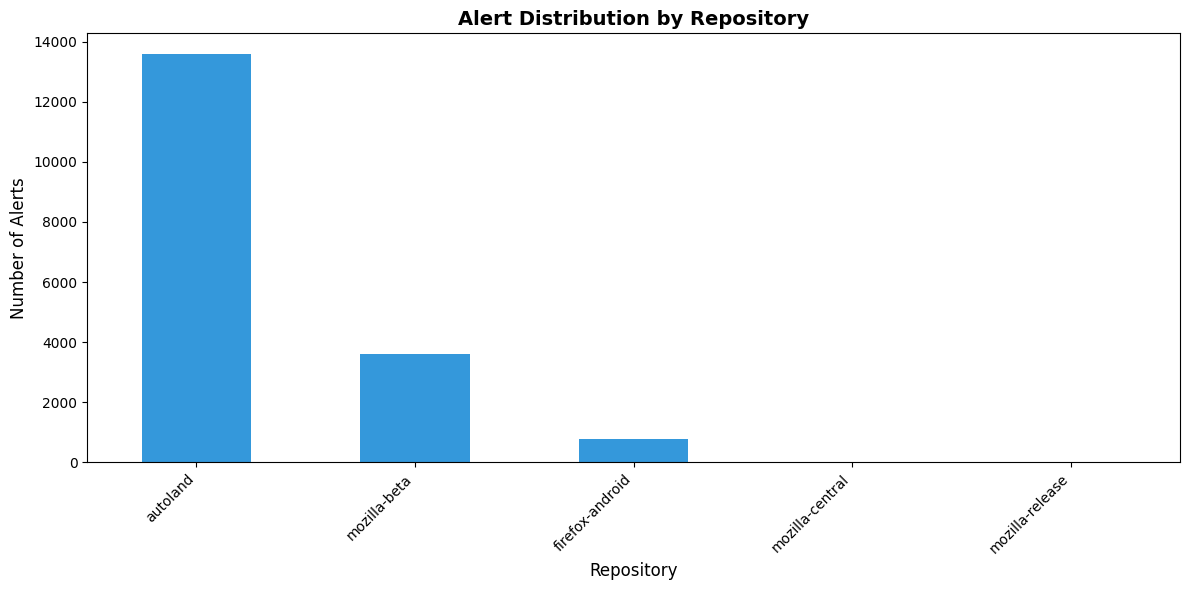

In [3]:
# Visualize repository distribution
plt.figure(figsize=(12, 6))
repo_counts.plot(kind='bar', color='#3498db')
plt.title('Alert Distribution by Repository', fontsize=14, fontweight='bold')
plt.xlabel('Repository', fontsize=12)
plt.ylabel('Number of Alerts', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../results/figures/repository_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Create Train/Test Splits by Repository

In [4]:
# Define training and test repositories
train_repo = 'autoland'
test_repos = ['mozilla-central', 'mozilla-beta']

# Check if these repositories exist
print(f"Checking repository availability...")
print(f"Train repository '{train_repo}': {train_repo in repo_counts.index}")
for repo in test_repos:
    print(f"Test repository '{repo}': {repo in repo_counts.index}")

# Create splits
train_mask = df_with_repo['repository'] == train_repo
test_mask = df_with_repo['repository'].isin(test_repos)

# Training data (autoland only)
X_train_repo = df_with_repo[train_mask].drop(['single_alert_is_regression', 'repository'], axis=1)
y_train_repo = df_with_repo[train_mask]['single_alert_is_regression'].astype(int)

# Test data (mozilla-central and mozilla-beta)
X_test_repo = df_with_repo[test_mask].drop(['single_alert_is_regression', 'repository'], axis=1)
y_test_repo = df_with_repo[test_mask]['single_alert_is_regression'].astype(int)

print(f"\nTraining set ({train_repo}): {X_train_repo.shape}")
print(f"Test set ({', '.join(test_repos)}): {X_test_repo.shape}")

print(f"\nClass distribution in training set:")
print(y_train_repo.value_counts())
print(f"\nClass distribution in test set:")
print(y_test_repo.value_counts())

Checking repository availability...
Train repository 'autoland': True
Test repository 'mozilla-central': True
Test repository 'mozilla-beta': True

Training set (autoland): (13593, 18)
Test set (mozilla-central, mozilla-beta): (3599, 18)

Class distribution in training set:
single_alert_is_regression
0    7464
1    6129
Name: count, dtype: int64

Class distribution in test set:
single_alert_is_regression
0    2440
1    1159
Name: count, dtype: int64


## 4. Train Model on Autoland Repository

In [5]:
# Calculate class balance for autoland
scale_pos_weight = (y_train_repo == 0).sum() / (y_train_repo == 1).sum()

# Train XGBoost model using utility function
model_repo = get_xgb_model(scale_pos_weight)

print(f"Training model on {train_repo} repository...")
print(f"Training samples: {len(X_train_repo)}")
print(f"Class balance weight: {scale_pos_weight:.2f}\n")

model_repo.fit(X_train_repo, y_train_repo)

print("Model training complete!")

Training model on autoland repository...
Training samples: 13593
Class balance weight: 1.22



Model training complete!


## 5. Evaluate on Held-Out Repositories

In [6]:
# Make predictions on test repositories
y_pred_repo = model_repo.predict(X_test_repo)
y_proba_repo = model_repo.predict_proba(X_test_repo)[:, 1]

# Calculate metrics
metrics_cross_repo = {
    'Accuracy': accuracy_score(y_test_repo, y_pred_repo),
    'Precision': precision_score(y_test_repo, y_pred_repo),
    'Recall': recall_score(y_test_repo, y_pred_repo),
    'F1-Score': f1_score(y_test_repo, y_pred_repo),
    'ROC-AUC': roc_auc_score(y_test_repo, y_proba_repo)
}

print("=" * 70)
print(f"CROSS-REPOSITORY PERFORMANCE")
print(f"Train: {train_repo} | Test: {', '.join(test_repos)}")
print("=" * 70)
for metric, value in metrics_cross_repo.items():
    print(f"{metric:12s}: {value:.4f}")
print("=" * 70)

CROSS-REPOSITORY PERFORMANCE
Train: autoland | Test: mozilla-central, mozilla-beta
Accuracy    : 0.9958
Precision   : 0.9906
Recall      : 0.9965
F1-Score    : 0.9935
ROC-AUC     : 0.9999


In [7]:
# Classification report
print("\nDetailed Classification Report:")
print("=" * 70)
print(classification_report(y_test_repo, y_pred_repo, 
                          target_names=['Noise/Improvement', 'Regression']))


Detailed Classification Report:
                   precision    recall  f1-score   support

Noise/Improvement       1.00      1.00      1.00      2440
       Regression       0.99      1.00      0.99      1159

         accuracy                           1.00      3599
        macro avg       0.99      1.00      1.00      3599
     weighted avg       1.00      1.00      1.00      3599



## 6. Evaluate Per Test Repository

In [8]:
# Get detailed performance per test repository
repo_df_test = df_with_repo[test_mask].copy()
repo_df_test['predictions'] = y_pred_repo
repo_df_test['probabilities'] = y_proba_repo

results_per_repo = []

print("Performance by Individual Test Repository:")
print("=" * 70)

for repo in test_repos:
    repo_mask = repo_df_test['repository'] == repo
    if repo_mask.sum() == 0:
        print(f"\nNo data for repository: {repo}")
        continue
    
    y_true_repo = repo_df_test[repo_mask]['single_alert_is_regression'].astype(int)
    y_pred_repo_specific = repo_df_test[repo_mask]['predictions']
    y_proba_repo_specific = repo_df_test[repo_mask]['probabilities']
    
    metrics = {
        'Repository': repo,
        'Samples': len(y_true_repo),
        'Accuracy': accuracy_score(y_true_repo, y_pred_repo_specific),
        'Precision': precision_score(y_true_repo, y_pred_repo_specific),
        'Recall': recall_score(y_true_repo, y_pred_repo_specific),
        'F1-Score': f1_score(y_true_repo, y_pred_repo_specific),
        'ROC-AUC': roc_auc_score(y_true_repo, y_proba_repo_specific)
    }
    
    results_per_repo.append(metrics)
    
    print(f"\n{repo}:")
    print(f"  Samples: {metrics['Samples']}")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  F1-Score: {metrics['F1-Score']:.4f}")
    print(f"  ROC-AUC:  {metrics['ROC-AUC']:.4f}")

# Create dataframe
results_df = pd.DataFrame(results_per_repo)
print("\n" + "=" * 70)
display(results_df)

Performance by Individual Test Repository:

mozilla-central:
  Samples: 2
  Accuracy: 1.0000
  F1-Score: 1.0000
  ROC-AUC:  1.0000

mozilla-beta:
  Samples: 3597
  Accuracy: 0.9958
  F1-Score: 0.9935
  ROC-AUC:  0.9999



,Repository,Samples,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,mozilla-central,2,1.00000,1.000000,1.000000,1.000000,1.00000
1,mozilla-beta,3597,0.99583,0.990558,0.996546,0.993543,0.99994


## 7. Comparison with In-Distribution Performance

In [9]:
# For comparison, let's also evaluate on autoland itself (in-distribution)
# Use a held-out portion of autoland
from sklearn.model_selection import train_test_split

# Split autoland data into train and validation
X_train_auto, X_val_auto, y_train_auto, y_val_auto = train_test_split(
    X_train_repo, y_train_repo, test_size=0.2, stratify=y_train_repo, random_state=42
)

# Retrain model on 80% of autoland
scale_pos_weight_split = (y_train_auto == 0).sum() / (y_train_auto == 1).sum()

model_indist = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=6,
    subsample=1.0,
    scale_pos_weight=scale_pos_weight_split,
    random_state=42,
    eval_metric='logloss'
)

model_indist.fit(X_train_auto, y_train_auto)

# Evaluate on validation set (remaining 20% of autoland)
y_pred_indist = model_indist.predict(X_val_auto)
y_proba_indist = model_indist.predict_proba(X_val_auto)[:, 1]

metrics_indist = {
    'Accuracy': accuracy_score(y_val_auto, y_pred_indist),
    'Precision': precision_score(y_val_auto, y_pred_indist),
    'Recall': recall_score(y_val_auto, y_pred_indist),
    'F1-Score': f1_score(y_val_auto, y_pred_indist),
    'ROC-AUC': roc_auc_score(y_val_auto, y_proba_indist)
}

print("IN-DISTRIBUTION PERFORMANCE (autoland validation set):")
print("=" * 70)
for metric, value in metrics_indist.items():
    print(f"{metric:12s}: {value:.4f}")
print("=" * 70)

IN-DISTRIBUTION PERFORMANCE (autoland validation set):
Accuracy    : 0.9963
Precision   : 0.9975
Recall      : 0.9943
F1-Score    : 0.9959
ROC-AUC     : 0.9999


In [10]:
# Create comparison dataframe
comparison_data = {
    'Setting': ['In-Distribution (autoland)', 'Cross-Repository (mozilla-*)'],
    'Train Repo': [train_repo, train_repo],
    'Test Repo': [train_repo, ', '.join(test_repos)],
    'Accuracy': [metrics_indist['Accuracy'], metrics_cross_repo['Accuracy']],
    'Precision': [metrics_indist['Precision'], metrics_cross_repo['Precision']],
    'Recall': [metrics_indist['Recall'], metrics_cross_repo['Recall']],
    'F1-Score': [metrics_indist['F1-Score'], metrics_cross_repo['F1-Score']],
    'ROC-AUC': [metrics_indist['ROC-AUC'], metrics_cross_repo['ROC-AUC']]
}

comparison_df = pd.DataFrame(comparison_data)

print("\nCOMPARISON: In-Distribution vs Cross-Repository")
print("=" * 70)
display(comparison_df)

# Calculate performance drop
print("\nPerformance Drop (Cross-Repository vs In-Distribution):")
print("=" * 70)
for metric in ['Accuracy', 'F1-Score', 'ROC-AUC']:
    drop = metrics_indist[metric] - metrics_cross_repo[metric]
    drop_pct = (drop / metrics_indist[metric]) * 100
    print(f"{metric:12s}: {drop:.4f} ({drop_pct:+.2f}%)")


COMPARISON: In-Distribution vs Cross-Repository


,Setting,Train Repo,Test Repo,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,In-Distribution (autoland),autoland,autoland,0.996322,0.997545,0.994290,0.995915,0.999871
1,Cross-Repository (mozilla-*),autoland,"mozilla-central, mozilla-beta",0.995832,0.990566,0.996549,0.993548,0.999940



Performance Drop (Cross-Repository vs In-Distribution):
Accuracy    : 0.0005 (+0.05%)
F1-Score    : 0.0024 (+0.24%)
ROC-AUC     : -0.0001 (-0.01%)


## 8. Visualize Results

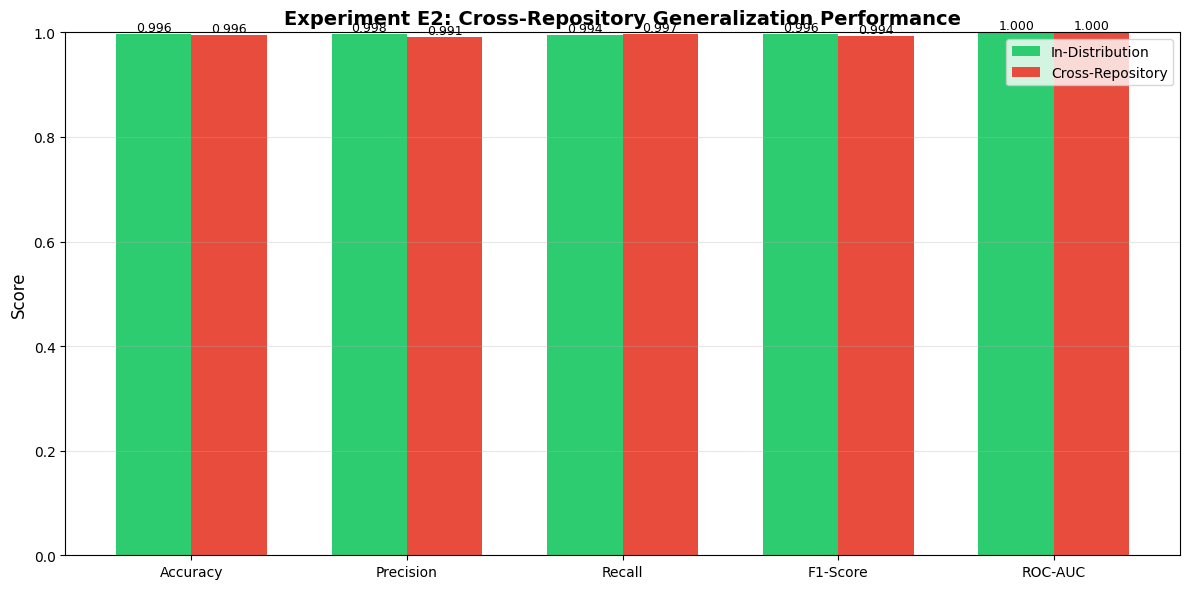

In [11]:
# Bar chart comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
indist_values = [comparison_df.iloc[0][m] for m in metrics_to_plot]
cross_values = [comparison_df.iloc[1][m] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, indist_values, width, label='In-Distribution', color='#2ecc71')
bars2 = ax.bar(x + width/2, cross_values, width, label='Cross-Repository', color='#e74c3c')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Experiment E2: Cross-Repository Generalization Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/cross_repository_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Key Findings

In [12]:
print("KEY FINDINGS - EXPERIMENT E2")
print("=" * 70)

print("\n1. Cross-Repository Generalization:")
f1_drop = metrics_indist['F1-Score'] - metrics_cross_repo['F1-Score']
if abs(f1_drop) < 0.05:
    print(f"   ✓ Model generalizes WELL to unseen repositories")
    print(f"   ✓ F1-Score drop: {f1_drop:.4f} (< 5% threshold)")
elif abs(f1_drop) < 0.10:
    print(f"   ~ Model shows MODERATE generalization")
    print(f"   ~ F1-Score drop: {f1_drop:.4f} (5-10% range)")
else:
    print(f"   ✗ Model shows POOR generalization")
    print(f"   ✗ F1-Score drop: {f1_drop:.4f} (> 10% threshold)")

print("\n2. Pattern Learning Assessment:")
if abs(f1_drop) < 0.05:
    print("   The model appears to learn REAL patterns, not repository-specific quirks")
else:
    print("   The model may be overfitting to repository-specific characteristics")

print("\n3. Recommendations:")
if abs(f1_drop) > 0.05:
    print("   - Consider training on multiple repositories")
    print("   - Add repository as a feature (if not already included)")
    print("   - Investigate repository-specific feature distributions")
else:
    print("   - Current approach is robust across repositories")
    print("   - Model is ready for production deployment")

print("\n" + "=" * 70)

KEY FINDINGS - EXPERIMENT E2

1. Cross-Repository Generalization:
   ✓ Model generalizes WELL to unseen repositories
   ✓ F1-Score drop: 0.0024 (< 5% threshold)

2. Pattern Learning Assessment:
   The model appears to learn REAL patterns, not repository-specific quirks

3. Recommendations:
   - Current approach is robust across repositories
   - Model is ready for production deployment



## 10. Save Results

In [13]:
# Save comparison results
comparison_df.to_csv('../results/metrics/cross_repository_results.csv', index=False)
results_df.to_csv('../results/metrics/per_repository_results.csv', index=False)

print("Results saved to results/ directory")
print("\nExperiment E2 complete!")

Results saved to results/ directory

Experiment E2 complete!
